In [310]:
from __future__ import division
from itertools import product, ifilter, izip, imap, chain, starmap, combinations
from functools import partial
from operator import getitem
from random import sample, seed
from collections import Counter

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output
from collections import Counter
from scipy.cluster.hierarchy import dendrogram, linkage

def indices( image ):
    return product(*map( range, image.shape ))

# Fast-Fourier Transform

The Fourier theorem says that any function of a real variable $f : \mathbb{R} \rightarrow \mathbb{R}$ can be expressed as,
$$
    f(x) = \frac{a_0}{2} + \sum_{n=0}^{\infty}{(a_n \cos nx + b_n \sin nx)}
$$
where the coefficients $a_n, b_n, c_n$ are given by,
$$
    a_n = \frac{2}{P}\int_{x_0}^{x_0+P} f(x)\cdot  \cos(\tfrac{2\pi nx}{P})\ dx \\
    b_n = \frac{2}{P}\int_{x_0}^{x_0+P} f(x)\cdot  \sin(\tfrac{2\pi nx}{P})\ dx \\
    c_n = \frac{1}{P}\int_{x_0}^{x_0+P} f(x)\cdot e^{-i \tfrac{2\pi nx}{P}}\ dx,
$$

# Hough Transforms

Given an image $\underset{m \times n}{I}$ and a shape described by $p$ parameters, the Hough transform $H$ is a $p$-dimensional space that maps every possible instance of the given shape to a value indicating its presence in $I$. A caveat here is that within an image there are exponentially many incarnations of a shape that could be present, to counter this the transform is provided with a resolution to search the parameter space with. That is, for each parameter an interval and step value is provide to discretization and control the run-time of the algorithm. This resolution then describes the size of the outputted transform, and it provides the mapping between elements in the transform and the parameters of the shape they represent. Another factor in searching for possible shape incarnations is the nature of the shape itself, more specifically the solvability of the system of equations used to describe the shape.

The process of detecting shapes in images using Hough transforms is to find shapes that have values in the transform greater than some threshold. Rarely is one actually looking for perfect incarnations of a given shape in an image, however the Hough transform still provides indication of where shape-like features exist. In the situation where a perfect shape exists there would appear a sharp maxima at the exact point in the transform corresponding to the associated shape, as the shape becomes more imperfect this maxima becomes less and less sharp. Hence in order to detect non-perfect shapes the program instead needs too look for regions of high intensity in the transform and pick a single shape within the blob to represent the feature.

## Hough Line Transform

Lines are characteristic of two parameters; the $r$ and $\varphi$ values of the equation $r = x\sin \varphi + y\cos \varphi$. This means for a given image $\underset{m \times n}{I}$ the Hough transform is two-dimensional space for which the dimensions are dependent on the resolution of a given parameter search space. 

In [292]:
def draw_image( image, ax = None ):
    if ax == None:
        fig, ax = plt.subplots()
        ax.imshow( image, cmap = 'Greys_r' )
        ax.axis( 'off' )
        plt.show()
    else:
        ax.imshow( image, cmap = 'Greys_r' )
        ax.axis( 'off' )

def draw_line( image, (r, phi) ):
    newImage = np.zeros( image.shape )
    transpose = phi < np.arctan2(*image.shape)
    if transpose:
        newImage = newImage.transpose()
        
    for x, y in indices( newImage ):
        if transpose:
            newImage[x, y] = image[y, x]
        else:
            newImage[x, y] = image[x, y]
        
    for x in range( newImage.shape[0] ):
        y = int((r - x * np.sin(phi)) / np.cos(phi)) \
            if transpose else \
            int((r - x * np.cos(phi)) / np.sin(phi))
        if 0 <= y < newImage.shape[1]:
            newImage[x, y] = 1
            
    return newImage.transpose() if transpose else newImage

def round_nearest( x, n ):
    ''' rounds x to the nearest multiple of n that is less than x '''
    return int(x / n) * n

def decrement_max( t ):
    l = list(t)
    l[ np.argmax(l) ] -= 1
    return tuple(l)

def hough_line_transform( image, resolution ):
    
    r_min, r_max, p_min, p_max, r_skip, p_skip = resolution
    
    hough = np.zeros((1 + int( (r_max - r_min) / r_skip ), \
                      1 + int( (p_max - p_min) / p_skip )))
    
    greq_zero = partial( getitem, image )
    for x, y in filter( greq_zero, indices( image ) ):
        for hy, p in enumerate(np.arange( p_min, p_max, p_skip )):
            r = x * np.cos(p) + y * np.sin(p)
            hx = round_nearest( r, r_skip ) - r_min
            hough[ hx, hy ] += 1
        
    return hough, lambda x, y : ((r_min + x * r_skip, 
                                  p_min + y * p_skip), hough[ x, y])

def accum_best( dist_fn, min_dist, thresh, acc, x ):
    p, v = x
    if v < thresh: return acc
    if acc == []: return [x]
    pl, vl = acc[-1]
    if dist_fn( pl, p ) > min_dist: return acc + [x]
    if vl < v: return acc[:-1] + [x]
    return acc

def hough_extract( hough_space, extract_fn, param_dist_fn,
                   thresh, min_dist ):
    items = list(starmap( extract_fn, indices( hough_space ) ))
    items.sort( key = lambda x : param_dist_fn( (0, 0), x[0] ) )
    accum = partial( accum_best, param_dist_fn, min_dist, thresh )
    params_votes = reduce( accum, items, [] )
    return [ p for p, v in params_votes ]

The following generates an image with `num_lines` random lines drawn across it and computes the Hough space with a given resolution for the parameter search.

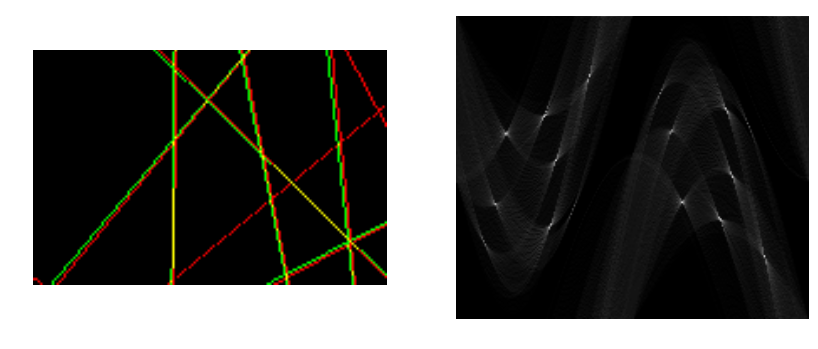

In [309]:
def demo_hough_lines( num_lines ):
    shape = 100, 150
    image = np.zeros(shape)
    
    seed(0)
    lines = zip(sample(range(max( *image.shape )), num_lines),
                sample(np.linspace(-np.pi, np.pi, 5*num_lines), num_lines))

    image = reduce( draw_line, lines, image )

    r_min, r_max = 0, int(np.hypot( *image.shape ))
    p_min, p_max = 0, np.pi * 2
    r_skip, p_skip = 1, 0.03
    resolution = ( r_min, r_max, p_min, p_max, r_skip, p_skip )
    image_lines, param_map = hough_line_transform( image, resolution )

    def euclid( (x1, y1), (x2, y2) ):
        return ( (x1 - x2)**2 + (y1 - y2)**2 )**0.5

    lines_h = hough_extract( image_lines, param_map, euclid, 20, 10 )

    image_h = reduce( draw_line, lines_h, np.zeros(shape) )

    image_c = np.zeros( image.shape + (3,) )
    for x, y in indices( image ):
        image_c[ x, y, 0 ] = image[x, y]
        image_c[ x, y, 1 ] = image_h[x, y]

    fig = plt.figure( figsize = (10, 10) )
    ax = fig.add_subplot( 121 )
    draw_image( image_c, ax )
    ax = fig.add_subplot( 122 )
    draw_image( image_lines, ax )
    plt.show()
    
for i in range( 1, 14 ):
    demo_hough_lines( i )
    clear_output( wait = True )

In the left image above, the red lines represent the original lines generated at random and the green lines represent the lines derived from the Hough transform. The right image shows the Hough transform as an image, areas of brightness correspond to more pixels voting that the associated lines appear in the input image. 

Run the cell above to see how the algorithm reacts to different arrangements. Tuning the `min_dist` and `thresh` values of the extracting parameters function also changes how many lines are detected.

## Hough Circle Transform

Circles are shapes described by the two parametric equations $x = x_0 + r \cos \varphi$ and $y = y_0 + r \sin \varphi$, hence a system of six variables, hence for the $x$ and $y$ values of white pixels in the input image the parameter search space is two dimensional - for every $r, \varphi$ pair possible there exists a single $x_0, y_0$ pair that satisfies the parametric equations. This makes the operation of updating the Hough transform for each $x, y$ run in quadratic time, this can be reduce to linear time by encoding an additional piece of information into the algorithm. By using the gradient image $\nabla I$ we can reduce the number of viable $x_0, y_0$ positions as,

\begin{align*}
    x_0 &= x \pm \cos \nabla I_{x,y} \\
    y_0 &= y \pm \sin \nabla I_{x,y} \\
\end{align*}